# Day 25

Use NFL play-by-play data from 1999 to create a dataset at the game-team level where I can see the score and the number of different types of scoring plays each team had that made up their final score. Ultimately I want to compare the percentage of score by offense/defense to see how teams perform and if there are any outliers at the weekly, team, or season level.

Today's update:
- Figured out why I was missing games. I was performing a LEFT JOIN where my left dataset were teams that scored at least one passing, rushing, or return touchdown on offense. This was incorrect and left out games where a team scored zero points, just a field goal, or other conditions.
- Figured out that the play-by-play dataset is missing only 3 games across the 1999-2022 seasons. I didn't filter out any games in the API call so I might need to manually check data in the [nflverse repository](https://github.com/nflverse/nflverse-data). Still, if I'm aggregating by season, 3 games isn't a significant issue when it comes to any statistcal analysis I might want to do in the future.

In [26]:
import pandas as pd
import sqlite3
import nfl_data_py as nfl
import matplotlib.pyplot as plt
import seaborn as sns

# Create database connection
conn = sqlite3.connect('../../data/db/database.db')

## Query Data

In [3]:
query = """
SELECT *
FROM pbp_score_summary
"""

df = pd.read_sql(query, conn)
print(len(df))
df.head()

12574


,game_id,team,sched_score,pbp_score,score_diff,tot_pass_tds,tot_rush_tds,tot_ret_tds,tot_extra_pts,tot_fgs,tot_2pt_conv,tot_def_tds,tot_safeties,tot_def_2pt,tot_off_fumble_recov_td
0,1999_01_MIN_ATL,ATL,14.0,14.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1999_01_KC_CHI,CHI,20.0,20.0,0.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0
2,1999_01_PIT_CLE,CLE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1999_01_OAK_GB,GB,28.0,28.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1999_01_BUF_IND,IND,31.0,31.0,0.0,2.0,1.0,0.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0


In [9]:
# Get season and week
df['season'] = df['game_id'].apply(lambda x: int(x[:4]))
df['week'] = df['game_id'].apply(lambda x: int(x[5:7]))

In [11]:
df.describe().round(2)

,sched_score,pbp_score,score_diff,tot_pass_tds,tot_rush_tds,tot_ret_tds,tot_extra_pts,tot_fgs,tot_2pt_conv,tot_def_tds,tot_safeties,tot_def_2pt,tot_off_fumble_recov_td,season,week
count,12574.00,12568.00,12568.0,12568.00,12568.00,12568.00,12568.00,12568.00,12568.00,12568.00,12568.00,12568.00,12568.00,12574.00,12574.00
mean,22.06,22.06,0.0,1.45,0.83,0.02,2.25,1.56,0.08,0.18,0.03,0.00,0.00,2010.36,9.43
std,10.28,10.28,0.0,1.14,0.92,0.16,1.47,1.19,0.28,0.43,0.18,0.03,0.07,6.80,5.28
min,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1999.00,1.00
25%,14.00,14.00,0.0,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,2004.00,5.00
50%,21.00,21.00,0.0,1.00,1.00,0.00,2.00,1.00,0.00,0.00,0.00,0.00,0.00,2010.00,9.00
75%,29.00,29.00,0.0,2.00,1.00,0.00,3.00,2.00,0.00,0.00,0.00,0.00,0.00,2016.00,14.00
max,62.00,62.00,0.0,7.00,8.00,2.00,8.00,8.00,4.00,4.00,2.00,1.00,1.00,2022.00,22.00


In [16]:
# Subset to regular season
reg_season = df.query("(season < 2021 & week < 17) | (season == 2021 & week < 18) | (season == 2022)")

<AxesSubplot: xlabel='week', ylabel='season'>

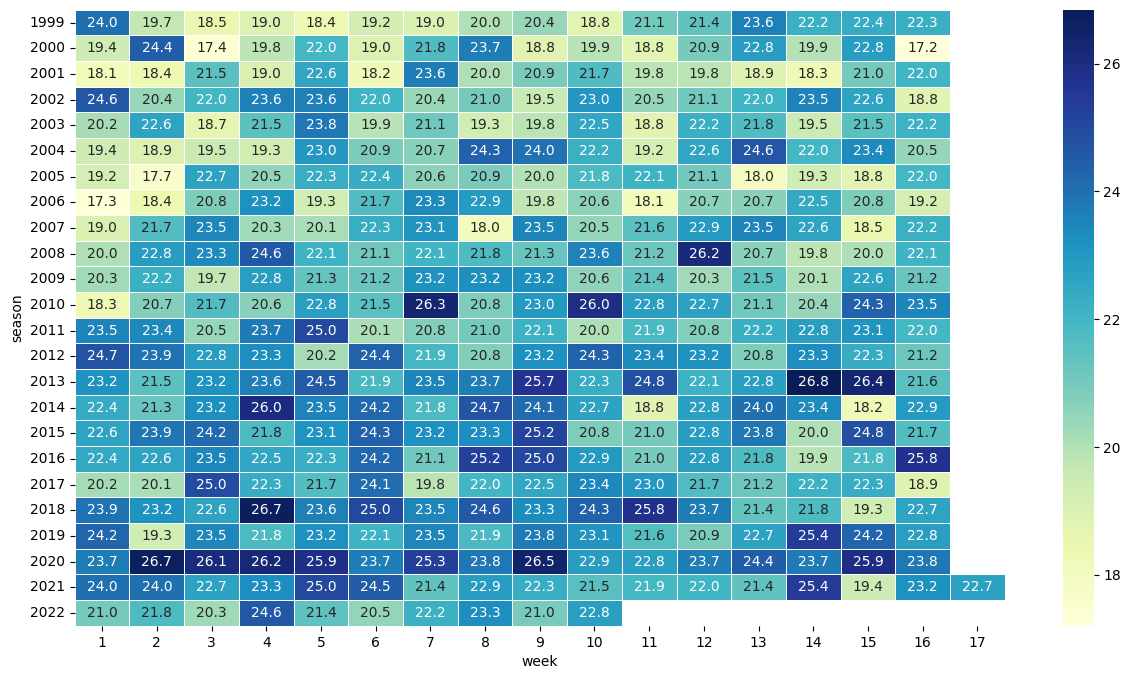

In [38]:
crosstab = pd.crosstab(
    reg_season['season'],
    reg_season['week'],
    values=reg_season['pbp_score'],
    dropna=True,
    aggfunc='mean'
)
# crosstab

plt.figure(figsize = (15,8))

sns.heatmap(
    crosstab,
    annot=True,
    fmt='.1f',
    cmap="YlGnBu",
    cbar=True,
    linewidth=.5
)

## Trying out different heatmaps...

In [42]:
def plot_heatmap(df, value, title):
    
    # Define crosstab
    crosstab = pd.crosstab(df['season'],
                           df['week'],
                           values=df[value],
                           dropna=True,
                           aggfunc='mean')

    # Plot Heatmap
    plt.figure(figsize = (15,8))

    g = sns.heatmap(
        crosstab,
        annot=True,
        fmt='.1f',
        cmap="YlGnBu",
        cbar=True,
        linewidth=.5
    )

    g.set_title(f"Heatmap of {title}", size=16)

    return plt.show()


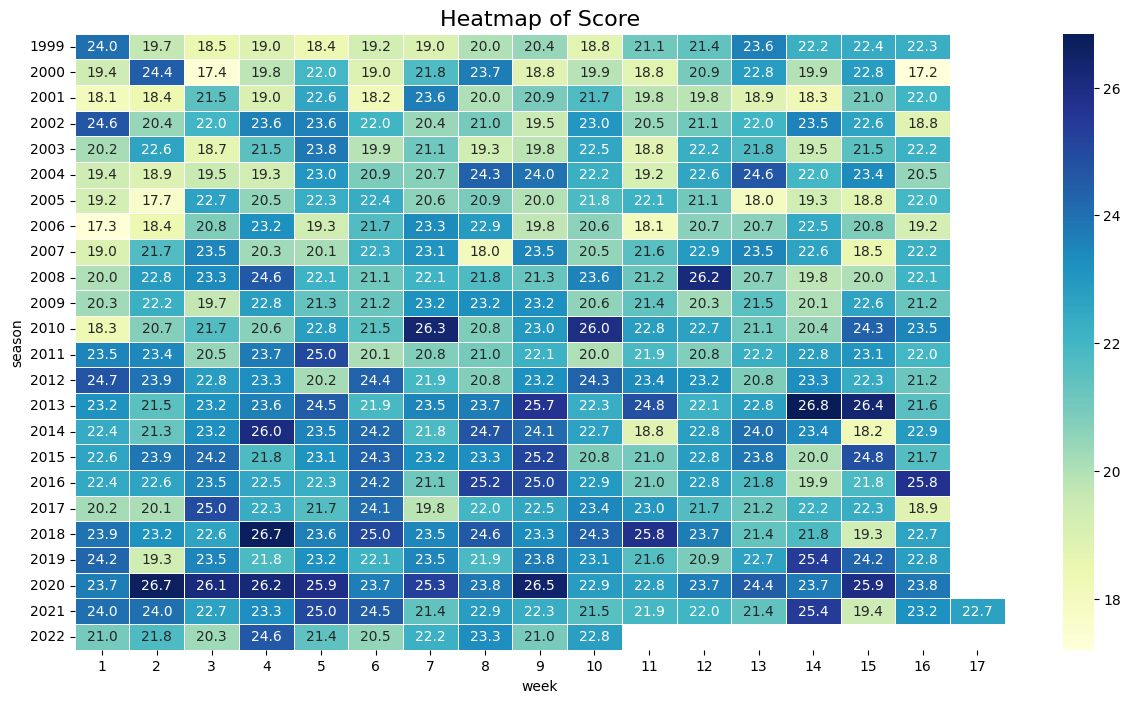

In [43]:
plot_heatmap(reg_season, 'pbp_score', "Score")

It seems like post 2010 there was an increase in average score per game.

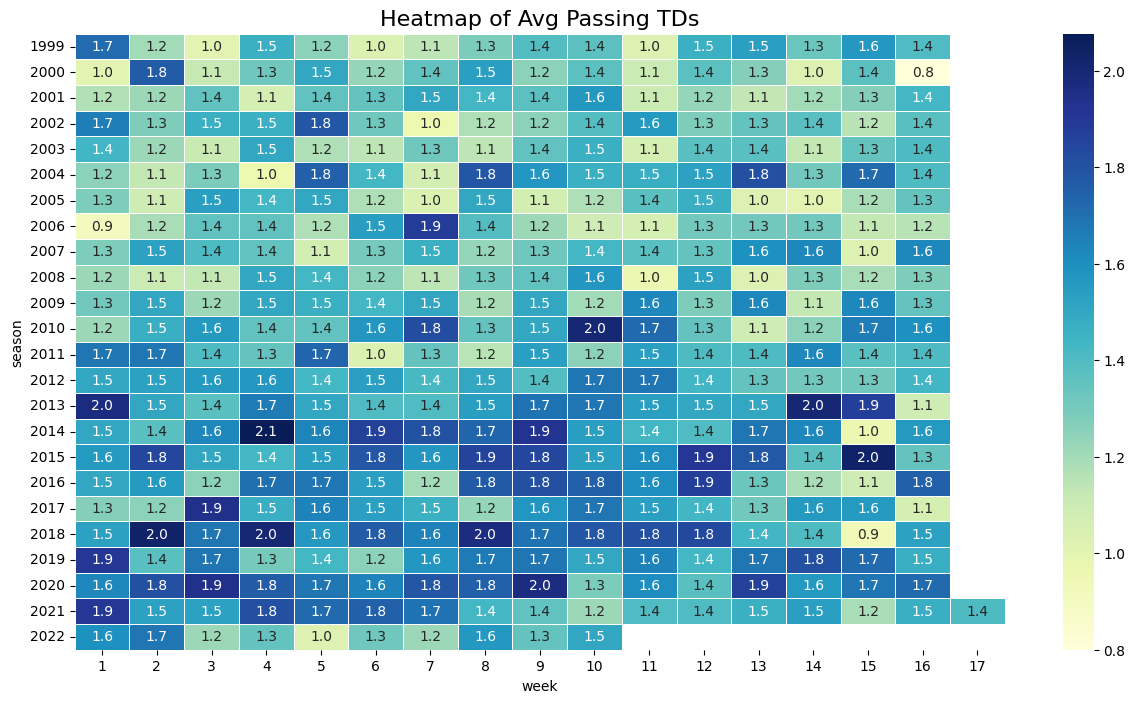

In [44]:
plot_heatmap(reg_season, 'tot_pass_tds', "Avg Passing TDs")

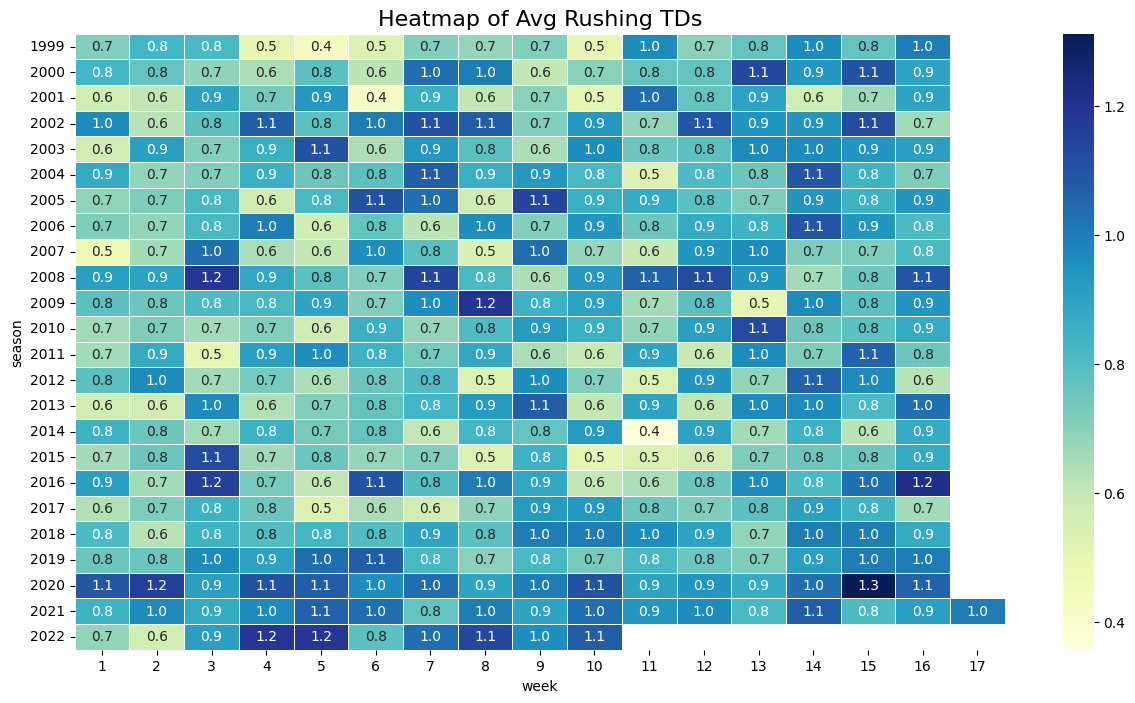

In [45]:
plot_heatmap(reg_season, 'tot_rush_tds', "Avg Rushing TDs")

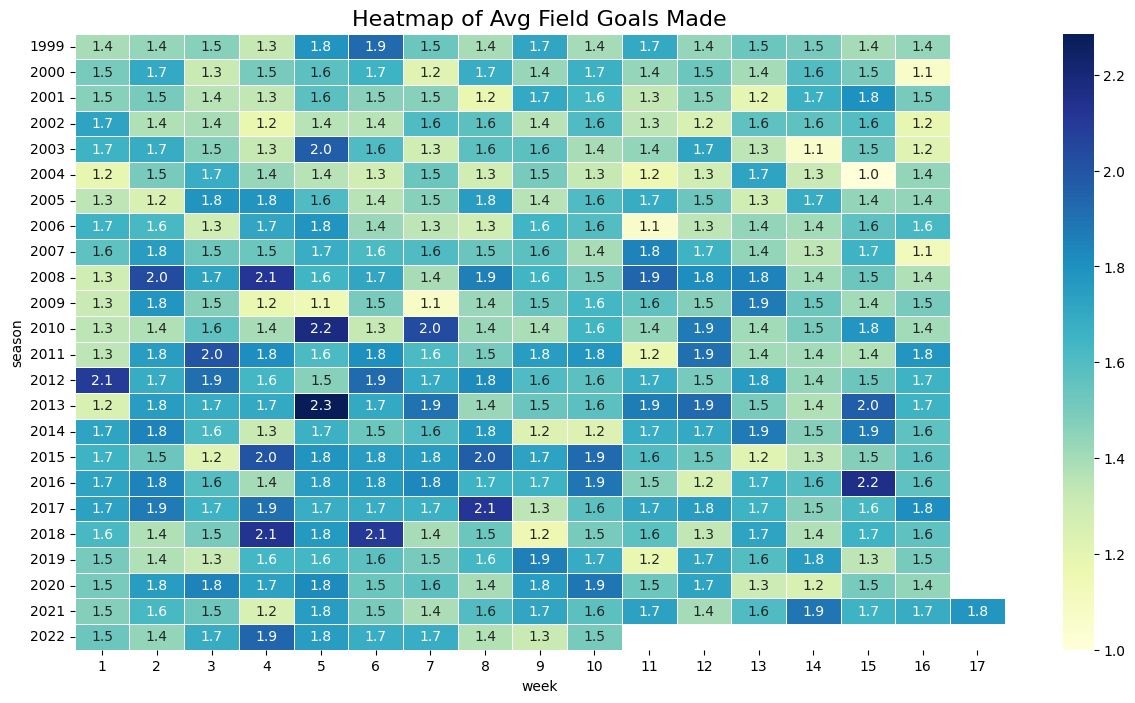

In [46]:
plot_heatmap(reg_season, 'tot_fgs', "Avg Field Goals Made")

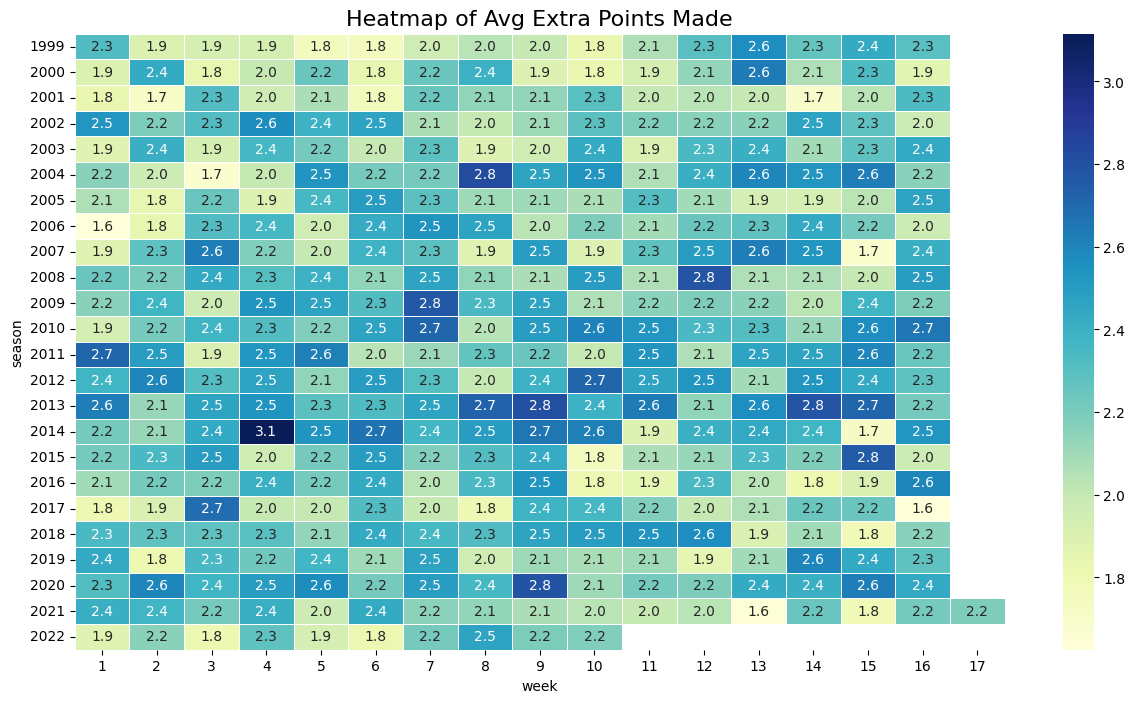

In [47]:
plot_heatmap(reg_season, 'tot_extra_pts', "Avg Extra Points Made")